In [15]:
import json

import numpy as np
import pandas as pd
import torch
from sklearn.metrics import r2_score, mean_squared_error

from fl_prog.utils.io import DEFAULT_DPATH_DATA, DEFAULT_DPATH_RESULTS, get_dpath_latest

CONDITIONS = [
    "100percent_3sites_50subjects",
    "50percent_3sites_50subjects",
    "0percent_3sites_50subjects",
]
N_ITERATIONS = 20

DPATH_DATA = get_dpath_latest(DEFAULT_DPATH_DATA)
DPATH_RESULTS = get_dpath_latest(DEFAULT_DPATH_RESULTS)

data_for_df = []
missing_counts = {condition: 0 for condition in CONDITIONS}
for condition in CONDITIONS:
    for i_iteration in range(1, N_ITERATIONS + 1):
        tag = f"{condition}_{i_iteration}"

        fpath_json_results = DPATH_RESULTS / tag / f"{tag}-estimated_params.json"
        if not fpath_json_results.exists():
            missing_counts[condition] += 1
            continue
        json_results = json.loads(fpath_json_results.read_text())
        results = json_results["results"]

        # load data
        fpath_json_data = DPATH_DATA / tag / f"{tag}.json"
        json_data = json.loads(fpath_json_data.read_text())
        cols = json_data["cols"]
        col_timepoint = cols["col_timepoint"]
        col_subject = cols["col_subject"]
        cols_biomarker = cols["cols_biomarker"]

        fpath_merged_data = DPATH_DATA / tag / f"{tag}-merged.tsv"
        df_merged = pd.read_csv(fpath_merged_data, sep="\t")

        # get original time points (before time shift)
        params = json_data["params"]
        x0_values = np.array(params["x0_values"])
        time_shifts = np.concatenate(params["time_shifts"])
        shifted_time = df_merged[col_timepoint] + time_shifts[df_merged[col_subject]]

        for i_biomarker, col_biomarker in enumerate(cols_biomarker):
            for setup in results.keys():
                estimated_k_values = np.array(results[setup]["estimated_k_values"])
                estimated_x0_values = np.array(results[setup]["estimated_x0_values"])

                mean_x_value_difference = (x0_values - estimated_x0_values).mean()

                y_true = df_merged[col_biomarker].to_numpy()
                y_pred = torch.sigmoid(
                    torch.tensor(
                        estimated_k_values[i_biomarker]
                        * (
                            shifted_time
                            - mean_x_value_difference
                            - estimated_x0_values[i_biomarker]
                        )
                    )
                )

                for metric, score_func in [
                    ("r2_score", r2_score),
                    ("mean_squared_error", mean_squared_error),
                ]:
                    data_for_df.append(
                        {
                            "condition": condition,
                            "iteration": i_iteration,
                            "tag": tag,
                            "col_biomarker": col_biomarker,
                            "setup": setup.capitalize(),
                            "metric": metric,
                            "score": score_func(y_true, y_pred.numpy()),
                        }
                    )

if sum(missing_counts.values()) == 0:
    print("All expected runs were found!")
else:
    print("Missing runs:")
    for condition, count in missing_counts.items():
        if count > 0:
            print(f"  {condition}: {count}")

df_results = pd.DataFrame(data_for_df)
display(df_results)

All expected runs were found!


,condition,iteration,tag,col_biomarker,setup,metric,score
0,100percent_3sites_50subjects,1,100percent_3sites_50subjects_1,biomarker_0,Centralized,r2_score,0.907216
1,100percent_3sites_50subjects,1,100percent_3sites_50subjects_1,biomarker_0,Centralized,mean_squared_error,0.010269
2,100percent_3sites_50subjects,1,100percent_3sites_50subjects_1,biomarker_0,Federated,r2_score,0.906861
3,100percent_3sites_50subjects,1,100percent_3sites_50subjects_1,biomarker_0,Federated,mean_squared_error,0.010308
4,100percent_3sites_50subjects,1,100percent_3sites_50subjects_1,biomarker_1,Centralized,r2_score,0.909680
...,...,...,...,...,...,...,...
1195,0percent_3sites_50subjects,20,0percent_3sites_50subjects_20,biomarker_3,Federated,mean_squared_error,0.100387
1196,0percent_3sites_50subjects,20,0percent_3sites_50subjects_20,biomarker_4,Centralized,r2_score,0.922512
1197,0percent_3sites_50subjects,20,0percent_3sites_50subjects_20,biomarker_4,Centralized,mean_squared_error,0.009189
1198,0percent_3sites_50subjects,20,0percent_3sites_50subjects_20,biomarker_4,Federated,r2_score,0.734365


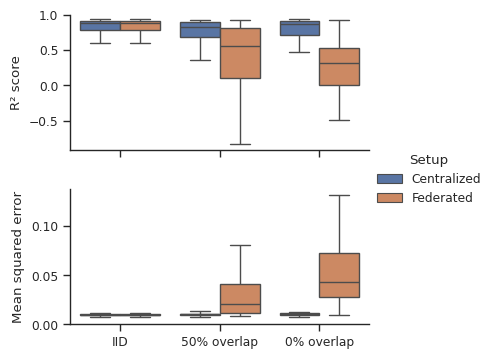

In [16]:
import seaborn as sns

sns.set_theme("paper", style="ticks")

LABEL_MAP = {
    "setup": "Setup",
    "federated": "Federated",
    "centralized": "Centralized",
    "r2_score": "R² score",
    "mean_squared_error": "Mean squared error",
    "100percent_3sites_50subjects": "IID",
    "50percent_3sites_50subjects": "50% overlap",
    "0percent_3sites_50subjects": "0% overlap",
}
METRIC_YLIM_MAP = {
    "r2_score": (None, 1.0),
    "mean_squared_error": (0.0, None),
}

grid_box = sns.catplot(
    data=df_results,
    kind="box",
    x="condition",
    y="score",
    hue="setup",
    row="metric",
    height=2,
    aspect=2,
    sharey=False,
    showfliers=False,
)

for metric, ax in grid_box.axes_dict.items():
    ax.set_title("")
    ax.set_ylabel(LABEL_MAP[metric])
    ax.set_xticks(ax.get_xticks())
    xticklabels = [
        LABEL_MAP.get(label.get_text(), label.get_text())
        for label in ax.get_xticklabels()
    ]
    if len(xticklabels) > 0:
        ax.set_xticklabels(xticklabels)
    ax.set_xlabel("")
    ax.set_ylim(METRIC_YLIM_MAP[metric])

legend = grid_box.legend
legend.set_title(LABEL_MAP[legend.get_title().get_text()])

In [17]:
fpath_fig_box = DPATH_RESULTS / "model_fit_comparison.svg"
grid_box.savefig(fpath_fig_box)
print(fpath_fig_box)

/data/origami/michelle/projects/fl-prog/results/2025_10_31/model_fit_comparison.svg
